https://github.com/roesenerm/MPT/blob/master/FinQuest%20-%20Investor's%20Optimal%20Portfolio.ipynb  \
https://www.youtube.com/watch?v=Mb4H3MaJnl8&list=PLLVfjXL2pnkQQXmBMPu_NIst57AKak5Z1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tushare as ts
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats
import math
import scipy.stats as scs
import statsmodels.api as sm
from pylab import mpl, plt
import datetime
from datetime import datetime
import matplotlib
from IPython.display import display
zhfont1 = matplotlib.font_manager.FontProperties(fname='C:\Windows\Fonts\msjh.ttc')


In [2]:
csv_name="智能保守2"
C2_old = pd.read_excel('ETF定期定額投組20200206_截至20200513.xlsx', skiprows = 1, sheet_name = '智能保守2數據(20200131) (原檔+處理漲跌值)' )
C2_new = pd.read_excel('豐存股(price).xlsm', skiprows = 4, sheet_name = '智能保守2指數' )
C2_new=C2_new.dropna(axis=1,how='all')  #把excel檔案第一欄的空值刪除
C2_old.drop(C2_old.columns[5:],axis=1,inplace=True)  #drop後面的五個欄位
C2_new.columns=['日期','0050_臺灣50指數','00646_標普指數(S&P 500)','00696B_ICE美國政府7-10年期債券指數','00697B_CE美國政府7-10年期債券指數']
C2_old.columns=['日期','0050_臺灣50指數','00646_標普指數(S&P 500)','00696B_ICE美國政府7-10年期債券指數','00697B_CE美國政府7-10年期債券指數']
data=pd.concat([C2_old,C2_new]) #合併old+new
data[:].fillna(method='ffill', inplace=True)  #先將nan用前一天的數值補上
data.set_index("日期" , inplace=True)
from datetime import date
today = date.today()
datestr = today.strftime('%Y-%m')
data=data.truncate(before = '2015-01')#將2015年之前的資料去掉
data=data.truncate(after = datestr)#將這個月的資料去掉

rf=0.0014 #設定無風險利率
data.head()

,0050_臺灣50指數,00646_標普指數(S&P 500),00696B_ICE美國政府7-10年期債券指數,00697B_CE美國政府7-10年期債券指數
日期,,,,
2015-01-01,6724.55,2058.90,1634.668,98.4575
2015-01-02,6724.55,2058.20,1650.562,98.8050
2015-01-05,6687.86,2020.58,1678.651,99.4367
2015-01-06,6489.45,2002.61,1704.304,100.0657
2015-01-07,6519.09,2025.90,1707.312,100.0835


In [3]:
data.tail()

,0050_臺灣50指數,00646_標普指數(S&P 500),00696B_ICE美國政府7-10年期債券指數,00697B_CE美國政府7-10年期債券指數
日期,,,,
2020-05-26,8390.52,2991.77,2422.3279,125.5064
2020-05-27,8404.65,3036.13,2425.0472,125.6967
2020-05-28,8343.67,3029.73,2404.8011,125.4916
2020-05-29,8341.10,3044.31,2434.7213,126.0114
2020-06-01,8435.86,3055.73,2413.4993,125.9060


In [4]:
prices = data
prices.head()

,0050_臺灣50指數,00646_標普指數(S&P 500),00696B_ICE美國政府7-10年期債券指數,00697B_CE美國政府7-10年期債券指數
日期,,,,
2015-01-01,6724.55,2058.90,1634.668,98.4575
2015-01-02,6724.55,2058.20,1650.562,98.8050
2015-01-05,6687.86,2020.58,1678.651,99.4367
2015-01-06,6489.45,2002.61,1704.304,100.0657
2015-01-07,6519.09,2025.90,1707.312,100.0835


In [5]:
cov_matrix = prices.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,0050_臺灣50指數,00646_標普指數(S&P 500),00696B_ICE美國政府7-10年期債券指數,00697B_CE美國政府7-10年期債券指數
0050_臺灣50指數,0.000102,0.000026,-0.000009,-0.000004
00646_標普指數(S&P 500),0.000026,0.000134,-0.000033,-0.000014
00696B_ICE美國政府7-10年期債券指數,-0.000009,-0.000033,0.000077,0.000028
00697B_CE美國政府7-10年期債券指數,-0.000004,-0.000014,0.000028,0.000012


In [6]:
e_r = prices.resample('Y').last().pct_change().mean()
e_r

0050_臺灣50指數                 0.076658
00646_標普指數(S&P 500)         0.092355
00696B_ICE美國政府7-10年期債券指數    0.087676
00697B_CE美國政府7-10年期債券指數     0.047965
dtype: float64

In [7]:
sd = prices.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
sd

0050_臺灣50指數                 0.159337
00646_標普指數(S&P 500)         0.183031
00696B_ICE美國政府7-10年期債券指數    0.138442
00697B_CE美國政府7-10年期債券指數     0.055213
dtype: float64

In [8]:
assets = pd.concat([e_r, sd], axis=1)
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
0050_臺灣50指數,0.076658,0.159337
00646_標普指數(S&P 500),0.092355,0.183031
00696B_ICE美國政府7-10年期債券指數,0.087676,0.138442
00697B_CE美國政府7-10年期債券指數,0.047965,0.055213


In [9]:
p_ret = []
p_vol = []
p_weights = []

num_assets = len(prices.columns)
num_portfolios = 8000

In [10]:
for portfolio in range(num_portfolios):
    a=0
    while a<500:   #設定跑500次，應該不至於500次都不符合需求(權重限制5~50%)
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        y1=weights>0.5
        y2=weights<0.05
        if y1.sum()+y2.sum()>0:
          a += 1
        else:
          break
    p_weights.append(weights)
    returns = np.dot(weights, e_r)
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(250)
    p_vol.append(ann_sd)

In [11]:
data = {'Returns':p_ret, 'Volatility':p_vol}

In [12]:
for counter, symbol in enumerate(prices.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [13]:
portfolios = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,0050_臺灣50指數 weight,00646_標普指數(S&P 500) weight,00696B_ICE美國政府7-10年期債券指數 weight,00697B_CE美國政府7-10年期債券指數 weight
0,0.075950,0.066951,0.164980,0.250422,0.305580,0.279017
1,0.080821,0.079970,0.292528,0.306892,0.272953,0.127628
2,0.080672,0.076825,0.302815,0.219584,0.359364,0.118236
3,0.066855,0.066178,0.184540,0.052830,0.283292,0.479339
4,0.076428,0.069956,0.086485,0.339827,0.274402,0.299286


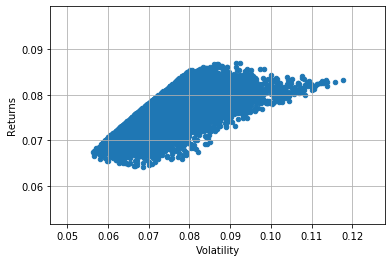

In [14]:
portfolios.plot.scatter(x='Volatility', y='Returns', grid=True)

Global Minimum Variance Portfolio

In [15]:
portfolios[portfolios['Volatility']==portfolios['Volatility'].min()]


,Returns,Volatility,0050_臺灣50指數 weight,00646_標普指數(S&P 500) weight,00696B_ICE美國政府7-10年期債券指數 weight,00697B_CE美國政府7-10年期債券指數 weight
5473,0.067465,0.056214,0.146585,0.182729,0.180862,0.489825


In [16]:
min_var_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
min_var_port

Returns                            0.067465
Volatility                         0.056214
0050_臺灣50指數 weight                 0.146585
00646_標普指數(S&P 500) weight         0.182729
00696B_ICE美國政府7-10年期債券指數 weight    0.180862
00697B_CE美國政府7-10年期債券指數 weight     0.489825
Name: 5473, dtype: float64

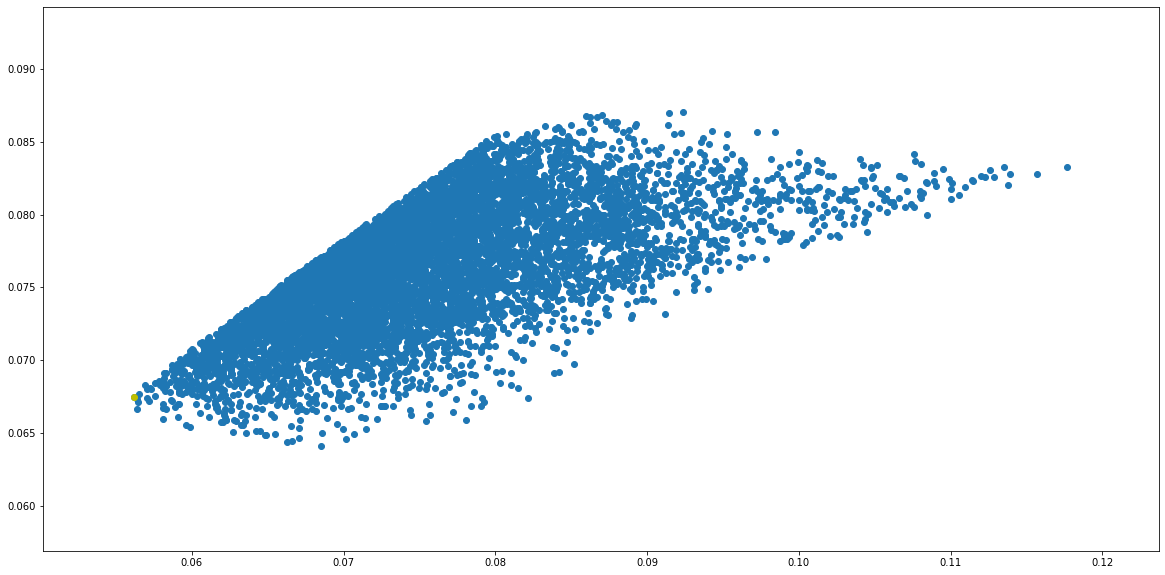

In [17]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(20,10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(min_var_port[1], min_var_port[0], color='y')

Optimal Risky Portfolio

In [18]:
rf = 0.0014
((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()

5473

In [19]:
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]

optimal_risky_port



Returns                            0.067465
Volatility                         0.056214
0050_臺灣50指數 weight                 0.146585
00646_標普指數(S&P 500) weight         0.182729
00696B_ICE美國政府7-10年期債券指數 weight    0.180862
00697B_CE美國政府7-10年期債券指數 weight     0.489825
Name: 5473, dtype: float64

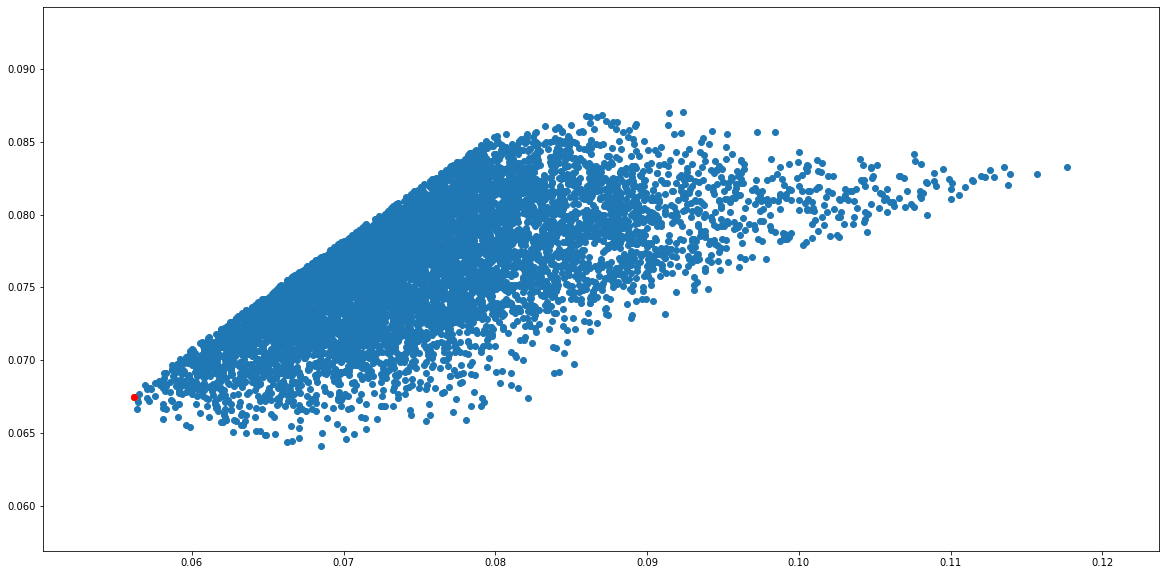

In [20]:
plt.subplots(figsize=(20,10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(min_var_port[1], min_var_port[0], color='orange')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='r')

Capital Allocation Line

In [21]:
cal_x = []
cal_y = []
utility = []
a = 10

In [22]:
for er in np.linspace(rf, max(p_ret), 20):
    sd = (er - rf)/((optimal_risky_port[0]-rf)/optimal_risky_port[1])
    u = er - .5*a*(sd**2)
    cal_x.append(sd)
    cal_y.append(er)
    utility.append(u)

In [23]:
data2 = {'utility':utility, 'cal_y':cal_y, 'cal_x':cal_x}
cal = pd.DataFrame(data2)
cal.head()

,utility,cal_y,cal_x
0,0.001400,0.001400,0.000000
1,0.005832,0.005906,0.003834
2,0.010117,0.010411,0.007668
3,0.014255,0.014917,0.011501
4,0.018247,0.019422,0.015335


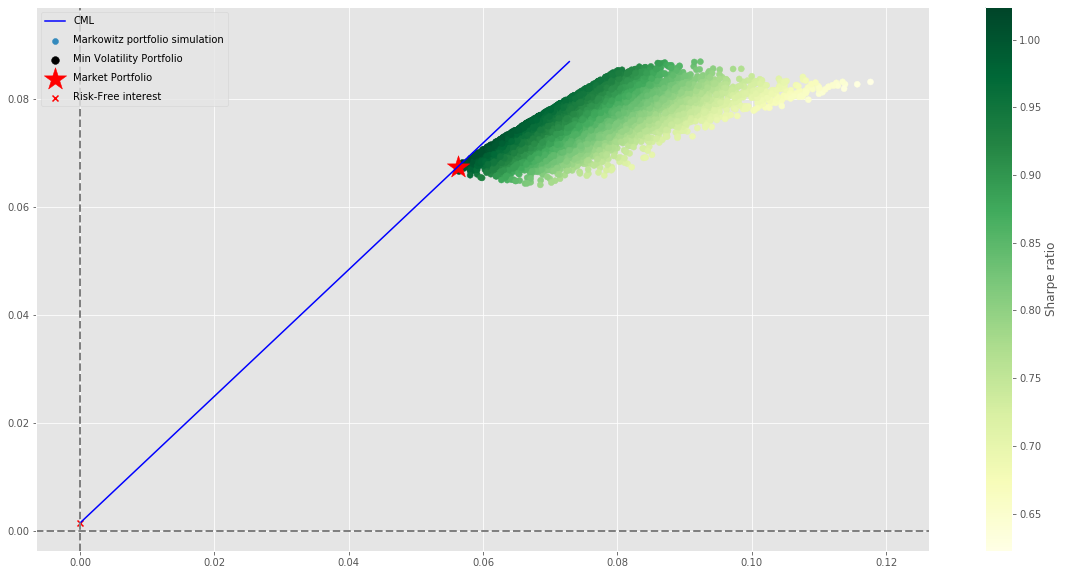

In [24]:
from pylab import mpl, plt
#plt.style.use('seaborn')
plt.style.use('ggplot')
#mpl.rcParams['font.family'] = 'serif'

plt.subplots(figsize=(20,10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],c=(portfolios['Returns']-0.01)/portfolios['Volatility'],cmap='YlGn')
plt.colorbar(label='Sharpe ratio')
plt.plot(cal_x, cal_y, color='blue')
plt.scatter(min_var_port[1], min_var_port[0], color='k',s=60)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0],marker='*',c='red',s=550)
plt.scatter(0, rf,marker='x',c='r')
plt.legend(('CML','Markowitz portfolio simulation','Min Volatility Portfolio','Market Portfolio','Risk-Free interest'),labelspacing=0.9 ,loc ='upper left')

#plt.grid(True)
plt.axhline(0,color='gray', ls='--', lw=2.0)
plt.axvline(0, color='gray', ls='--', lw=2.0)



In [25]:
result=pd.DataFrame(optimal_risky_port)
result.columns=['Information']

portfolio=result[2:]*100
portfolio.columns=['投資組合配重%']
portfolio.index=['元大台灣50','元大S&P500','富邦美債20年','元大美債7-10年']
#display(portfolio)

In [26]:
"""
date = datetime.today().strftime('%Y-%m-%d')
result=pd.DataFrame(optimal_risky_port)
result.columns=['Information']
print(date)
portfolio=result[2:]*100
portfolio.columns=['投資組合配重%']
portfolio.index=['元大台灣50','元大S&P500','富邦美債20年','元大美債7-10年']
portfolio"""

"\ndate = datetime.today().strftime('%Y-%m-%d')\nresult=pd.DataFrame(optimal_risky_port)\nresult.columns=['Information']\nprint(date)\nportfolio=result[2:]*100\nportfolio.columns=['投資組合配重%']\nportfolio.index=['元大台灣50','元大S&P500','富邦美債20年','元大美債7-10年']\nportfolio"

In [27]:
result.iloc[0:2]

,Information
Returns,0.067465
Volatility,0.056214


In [28]:
portfolio2=np.around(np.array(pd.Series(portfolio.iloc[:,0])),decimals=2) #把最新的配重結果存下來，存成portfolio2，放到後面繪圖使用

In [29]:
#參考https://www.jianshu.com/p/4cc811402477
portfolio_weights_original = np.array([0.15,0.22,0.13,0.5])  #期初第一次權重
portfolio_weights_average = np.array([0.25,0.25,0.25,0.25])       #平均權重
portfolio_weights_latest = portfolio2/100                         #最新權重


In [30]:
#截取今日日期
date = datetime.today().strftime('%Y-%m-%d')

#print(date)

#計算是否有需要調整權重，門檻是有其中一個權重偏移10%以上
j=0
for i in range(len(prices.columns)):
    if abs(portfolio_weights_original[i]-portfolio_weights_latest[i])>0.1 :
        j+=1;
if j>0:
    print(date+"  "+"\033[46m本次運算結果，符合調整權重!")
else:
    print(date+"  "+"本次運算結果，不需要調整。")
    
display(portfolio)

2020-06-12  本次運算結果，不需要調整。


,投資組合配重%
元大台灣50,14.658472
元大S&P500,18.272893
富邦美債20年,18.086155
元大美債7-10年,48.982481


Investor's Optimal Portfolio

In [31]:
cal['utility'].idxmax()


19

In [32]:
investors_port = cal.iloc[cal['utility'].idxmax()]
investors_port

utility    0.060476
cal_y      0.087006
cal_x      0.072842
Name: 19, dtype: float64

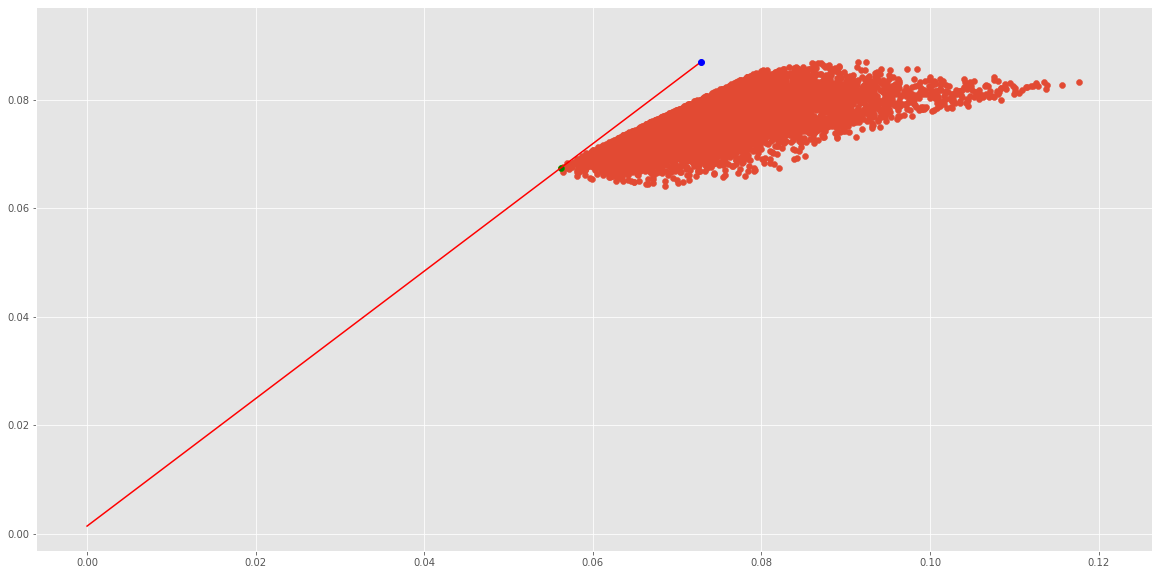

In [33]:
plt.subplots(figsize=(20,10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(min_var_port[1], min_var_port[0], color='y')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g')
plt.plot(cal_x, cal_y, color='r')
plt.plot(investors_port[2], investors_port[1], 'o', color='b')

In [34]:
#繪圖回測
C2_old = pd.read_excel('ETF定期定額投組20200206_截至20200513.xlsx', skiprows = 1, sheet_name = '智能保守2數據(20200131) (原檔+處理漲跌值)' )
C2_new = pd.read_excel('豐存股(price).xlsm', skiprows = 4, sheet_name = '智能保守2指數' )
C2_new=C2_new.dropna(axis=1,how='all')  #把excel檔案第一欄的空值刪除
C2_old.drop(C2_old.columns[5:],axis=1,inplace=True)  #drop後面的五個欄位
C2_new.columns=['日期','0050_臺灣50指數','00646_標普指數(S&P 500)','00696B_ICE美國政府7-10年期債券指數','00697B_CE美國政府7-10年期債券指數']
C2_old.columns=['日期','0050_臺灣50指數','00646_標普指數(S&P 500)','00696B_ICE美國政府7-10年期債券指數','00697B_CE美國政府7-10年期債券指數']
data=pd.concat([C2_old,C2_new]) #合併old+new
data[:].fillna(method='ffill', inplace=True)  #先將nan用前一天的數值補上
data.set_index("日期" , inplace=True)
from datetime import date
today = date.today()
datestr = today.strftime('%Y-%m')
data=data.truncate(before = '2018-06')#將2018-06年之前的資料去掉
data=data.truncate(after = datestr)#將這個月的資料去掉

In [35]:
'''
#參考https://www.jianshu.com/p/4cc811402477
portfolio_weights_original = np.array([0.15,0.22,0.13,0.5])  #期初第一次權重
portfolio_weights_average = np.array([0.2,0.2,0.2,0.2])       #平均權重
portfolio_weights_latest = portfolio2/100                         #最新權重'''

'\n#參考https://www.jianshu.com/p/4cc811402477\nportfolio_weights_original = np.array([0.15,0.22,0.13,0.5])  #期初第一次權重\nportfolio_weights_average = np.array([0.2,0.2,0.2,0.2])       #平均權重\nportfolio_weights_latest = portfolio2/100                         #最新權重'

In [36]:
prices2=data

In [37]:
prices2

,0050_臺灣50指數,00646_標普指數(S&P 500),00696B_ICE美國政府7-10年期債券指數,00697B_CE美國政府7-10年期債券指數
日期,,,,
2018-06-01,8104.79,2734.62,1702.1960,100.9953
2018-06-04,8250.00,2746.87,1691.4620,100.6709
2018-06-05,8247.77,2748.80,1694.1590,100.8477
2018-06-06,8314.51,2772.35,1677.8070,100.4411
2018-06-07,8364.17,2770.37,1692.7810,100.7627
...,...,...,...,...
2020-05-26,8390.52,2991.77,2422.3279,125.5064
2020-05-27,8404.65,3036.13,2425.0472,125.6967
2020-05-28,8343.67,3029.73,2404.8011,125.4916


In [38]:
prices2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518 entries, 2018-06-01 to 2020-06-01
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   0050_臺灣50指數               518 non-null    float64
 1   00646_標普指數(S&P 500)       518 non-null    float64
 2   00696B_ICE美國政府7-10年期債券指數  518 non-null    float64
 3   00697B_CE美國政府7-10年期債券指數   518 non-null    float64
dtypes: float64(4)
memory usage: 20.2 KB


In [39]:
import ffn

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [40]:

strategies_original = (prices2.rebase() * portfolio_weights_original).mean(axis=1).rebase()
strategies_average = (prices2.rebase() * portfolio_weights_average).mean(axis=1).rebase()
strategies_latest = (prices2.rebase() * portfolio_weights_latest).mean(axis=1).rebase()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26399 missing from current font.
  font.set_text(s, 0, flags=flags)


期初配置權重(%)
[15. 22. 13. 50.]
平均配置權重(%)
[25. 25. 25. 25.]
最新一次再平衡配置權重(%)
[14.66 18.27 18.09 48.98]


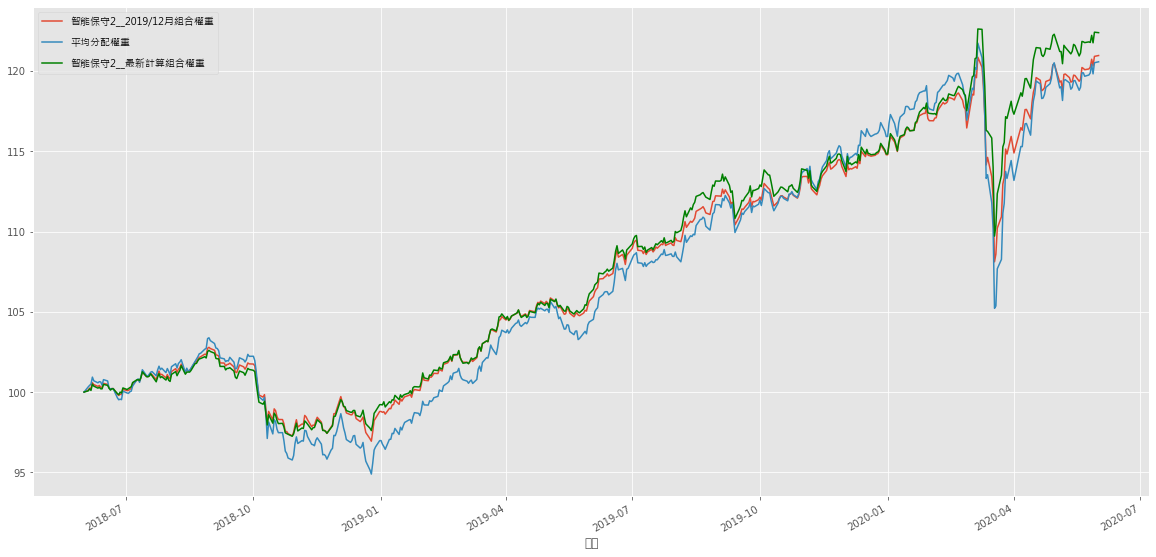

In [41]:
plt.subplots(figsize=(20,10))
strategies_original.plot()
strategies_average.plot()
strategies_latest.plot(color='g')
plt.legend((csv_name+'__2019/12月組合權重','平均分配權重',csv_name+'__最新計算組合權重'),labelspacing=0.9 ,loc ='upper left',prop=zhfont1)
#plt.title(csv_name+'回測績效')

print("期初配置權重(%)")
print(portfolio_weights_original*100)
print("平均配置權重(%)")
print(portfolio_weights_average*100)
print("最新一次再平衡配置權重(%)")
print(portfolio_weights_latest*100)


In [42]:
#Log record

date = datetime.today().strftime('%Y%m%d')
H = datetime.today().strftime('%H')
M = datetime.today().strftime('%M')
S = datetime.today().strftime('%S')
f1=open('log.txt','a')  #寫入log
f1.write("\n於"+date+'--'+H+':'+M+':'+S+'成功執行'+csv_name+'再平衡運算')
f1.write("\n")
f1.close()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26399 missing from current font.
  font.set_text(s, 0, flags=flags)


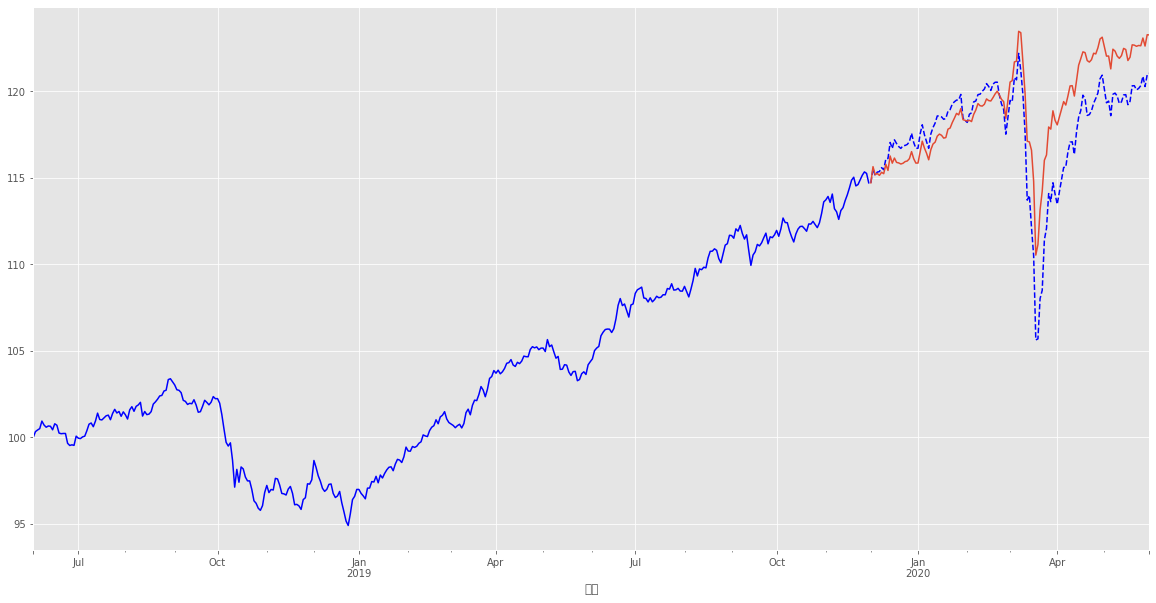

In [43]:
#調整權重之前的績效
   #取資料
   #data_un: 調權重之前的績效需要的資料，調整之前，大家績效都一樣，基準點用平均權重做比較
C2_old = pd.read_excel('ETF定期定額投組20200206_截至20200513.xlsx', skiprows = 1, sheet_name = '智能保守2數據(20200131) (原檔+處理漲跌值)' )
C2_new = pd.read_excel('豐存股(price).xlsm', skiprows = 4, sheet_name = '智能保守2指數' )
C2_new=C2_new.dropna(axis=1,how='all')  #把excel檔案第一欄的空值刪除
C2_old.drop(C2_old.columns[5:],axis=1,inplace=True)  #drop後面的五個欄位
C2_new.columns=['日期','0050_臺灣50指數','00646_標普指數(S&P 500)','00696B_ICE美國政府7-10年期債券指數','00697B_CE美國政府7-10年期債券指數']
C2_old.columns=['日期','0050_臺灣50指數','00646_標普指數(S&P 500)','00696B_ICE美國政府7-10年期債券指數','00697B_CE美國政府7-10年期債券指數']
data_un=pd.concat([C2_old,C2_new]) #合併old+new
data_un[:].fillna(method='ffill', inplace=True)  #先將nan用前一天的數值補上
data_un.set_index("日期" , inplace=True)
from datetime import date
today = date.today()
datestr = today.strftime('%Y-%m')
data_un=data_un.truncate(before = '2018-06')#將之前的資料去掉
data_un=data_un.truncate(after = '2019-12')#將這個月的資料去掉
   #算績效漲跌
prices_un=data_un    
portfolio_weights_average = np.array([0.2,0.2,0.2,0.2])       #平均權重
strategies_average_un = (prices_un.rebase() * portfolio_weights_average).mean(axis=1).rebase()


   
    
    
    

#不調整權重的後來一個月績效
   #data_after: 調權重之後的一個月績效需要的資料，與不調整的績效，共用同一份資料

C2_old = pd.read_excel('ETF定期定額投組20200206_截至20200513.xlsx', skiprows = 1, sheet_name = '智能保守2數據(20200131) (原檔+處理漲跌值)' )
C2_new = pd.read_excel('豐存股(price).xlsm', skiprows = 4, sheet_name = '智能保守2指數' )
C2_new=C2_new.dropna(axis=1,how='all')  #把excel檔案第一欄的空值刪除
C2_old.drop(C2_old.columns[5:],axis=1,inplace=True)  #drop後面的五個欄位
C2_new.columns=['日期','0050_臺灣50指數','00646_標普指數(S&P 500)','00696B_ICE美國政府7-10年期債券指數','00697B_CE美國政府7-10年期債券指數']
C2_old.columns=['日期','0050_臺灣50指數','00646_標普指數(S&P 500)','00696B_ICE美國政府7-10年期債券指數','00697B_CE美國政府7-10年期債券指數']
data_after=pd.concat([C2_old,C2_new]) #合併old+new
data_after[:].fillna(method='ffill', inplace=True)  #先將nan用前一天的數值補上
data_after.set_index("日期" , inplace=True)
from datetime import date
today = date.today()
datestr = today.strftime('%Y-%m')
data_after=data_after.truncate(before = '2019-12')#將之前的資料去掉
data_after=data_after.truncate(after = '2020-06')#將這個月的資料去掉

prices_after=data_after    
portfolio_weights_average = np.array([0.2,0.2,0.2,0.2])       #這邊用平均權重作為對比
strategies_average_after = (prices_after.rebase() * portfolio_weights_average).mean(axis=1).rebase()
strategies_average_after = strategies_average_after * strategies_average_un[-1]/100





#調整權重之後一個月的績效

prices_after=data_after    
portfolio_weights_latest = portfolio2/100                         #最新權重
strategies_latest_after = (prices_after.rebase() * portfolio_weights_latest).mean(axis=1).rebase()
strategies_latest_after = strategies_latest_after * strategies_average_un[-1]/100




plt.subplots(figsize=(20,10))
strategies_average_un.plot(c='b')
strategies_average_after.plot(ls='--',c='b')
strategies_latest_after.plot()


In [46]:
#讀出原本權重
portfolio_table=pd.read_excel('豐存股再平衡結果.xlsx', skiprows = 0, sheet_name = csv_name)
from openpyxl import load_workbook
import openpyxl

t=len(portfolio_table.index)-1
#讀出起始與最後日期
r=np.arange(0,t+1)
plot_date=pd.DataFrame(columns=['區間起始日','區間結束日','紀錄收益值'],index=r)
plot_date
plot_pro_series=pd.Series([])

#建立平均權重的串列
b=1/num_assets
portfolio_weights_average = np.array([b]*num_assets)

z=0  #後面用來計數plot_date裡面的次數

for j in range(1,t+1):  
    #Data拆分段, 取日期資料，作為放入讀取資料的運算，截取需要的部分
    csv_name="智能保守2"
    C2_old = pd.read_excel('ETF定期定額投組20200206_截至20200513.xlsx', skiprows = 1, sheet_name = '智能保守2數據(20200131) (原檔+處理漲跌值)' )
    C2_new = pd.read_excel('豐存股(price).xlsm', skiprows = 4, sheet_name = '智能保守2指數' )
    C2_new=C2_new.dropna(axis=1,how='all')  #把excel檔案第一欄的空值刪除
    C2_old.drop(C2_old.columns[5:],axis=1,inplace=True)  #drop後面的五個欄位
    C2_new.columns=['日期','0050_臺灣50指數','00646_標普指數(S&P 500)','00696B_ICE美國政府7-10年期債券指數','00697B_CE美國政府7-10年期債券指數']
    C2_old.columns=['日期','0050_臺灣50指數','00646_標普指數(S&P 500)','00696B_ICE美國政府7-10年期債券指數','00697B_CE美國政府7-10年期債券指數']
    data=pd.concat([C2_old,C2_new]) #合併old+new
    data[:].fillna(method='ffill', inplace=True)  #先將nan用前一天的數值補上
    data.set_index("日期" , inplace=True)

    data=data.truncate(before = portfolio_table.iloc[0+j,2].date())#將此之前的資料去掉
    data=data.truncate(after = portfolio_table.iloc[0+j,3].date())#將後面的資料去掉
    
    #計算各期權重變化    #設定2019-09/10/11/12, 2020-01/02/03/04/05
    prices = data
    cov_matrix = prices.pct_change().apply(lambda x: np.log(1+x)).cov()
    e_r = prices.resample('Y').last().pct_change().mean()
    sd = prices.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
    
    assets = pd.concat([e_r, sd], axis=1)
    assets.columns = ['Returns', 'Volatility']
    
    p_ret = []
    p_vol = []
    p_weights = []
    num_assets = len(prices.columns)
    num_portfolios = 8000
    
    for portfolio in range(num_portfolios):
        a=0
        while a<500:   #設定跑500次，應該不至於500次都不符合需求(權重限制5~50%)
            weights = np.random.random(num_assets)
            weights = weights/np.sum(weights)
            y1=weights>0.5
            y2=weights<0.05
            if y1.sum()+y2.sum()>0:
              a += 1
            else:
              break
        p_weights.append(weights)
        returns = np.dot(weights, e_r)
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        sd = np.sqrt(var)
        ann_sd = sd*np.sqrt(250)
        p_vol.append(ann_sd)
    
    data = {'Returns':p_ret, 'Volatility':p_vol}
    
    for counter, symbol in enumerate(prices.columns.tolist()):
        data[symbol+' weight'] = [w[counter] for w in p_weights]
    
    portfolios = pd.DataFrame(data)
    portfolios[portfolios['Volatility']==portfolios['Volatility'].min()]
    
    min_var_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
    optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]


    cal_x = []
    cal_y = []
    utility = []
    a = 10

    for er in np.linspace(rf, max(p_ret), 20):
        sd = (er - rf)/((optimal_risky_port[0]-rf)/optimal_risky_port[1])
        u = er - .5*a*(sd**2)
        cal_x.append(sd)
        cal_y.append(er)
        utility.append(u)
        
    data2 = {'utility':utility, 'cal_y':cal_y, 'cal_x':cal_x}
    cal = pd.DataFrame(data2)
    cal.head()
    
    result=pd.DataFrame(optimal_risky_port)
    result.columns=['Information']
    
    portfolio=result[2:]*100
    portfolio.columns=['投資組合配重%']
    portfolio.index=['0050_臺灣50指數','00646_標普指數(S&P 500)','00696B_ICE美國政府7-10年期債券指數','00697B_CE美國政府7-10年期債券指數']
    #display(portfolio)
    #前面已經宣告，portfolio2是做CML運算後的結果
    portfolio2=np.around(np.array(pd.Series(portfolio.iloc[:,0])),decimals=2) 
                             #把最新的配重結果存下來，存成portfolio2(ndarray格式)，如需要繪圖可以使用
    portfolio_table.iloc[0+j,10:]=portfolio2  
                             #將本次運算結果portfolio2轉成一個dataframe,然後塞回portfolio_table 
    
    """
    #將收益率/波動度/夏普值存到portfolio_table.iloc[0+j,7:9]
    portfolio_table.iloc[0+j,7]=result.iloc[0]  
    portfolio_table.iloc[0+j,8]=result.iloc[1]  
    
    #計算Sharpe值
    #strategies_average = (prices.rebase() * portfolio2).mean(axis=1).rebase()
    sharpe=(result.iloc[0]-rf)/result.iloc[1] 
    portfolio_table.iloc[0+j,9]=sharpe
    """   
    
    """ 
    q=0
    #往回找，判斷往前最後一次flag出現在哪一行
    if j==1:
        q=1  #代表往前一行，找到第一筆正式發布，就是比較對象
    if j>1:
        for y in range(1,j+1):
            if portfolio_table.iloc[0+j-y,5]==1:
                break
            y+=1
            q=y  #代表，往前y行，會遇到最後一個flag=1
    """
    t=len(portfolio_table.iloc[:,3])-1   #這個數字是代表要算幾期，其實也等於往前算幾個月
    #  t=6
    for d in range(1,t+1):
        portfolio_table.iloc[d,0]=portfolio_table.iloc[0,0]+d  #把編號填上去
    
    
    #讀出權重並判斷是否要變動 (flag)
    if j==1: #第一回比較，拿第一次的權重比，而第一次的權重是直接讀取出來的
        portfolio_weights_latest[:]=portfolio_table.iloc[0,10:]
        
        
    portfolio_table.iloc[0+j,5]=0 #先把flag歸0，後面符合條件才改為1
    for p in range(num_assets):
        if abs(portfolio_table.iloc[j,10+p]-portfolio_weights_latest[p])>=10 :
            portfolio_table.iloc[0+j,5]=1  #設定portfolio_table.iloc[0+j,5]存放      
    
    if portfolio_table.iloc[0+j,5]==1 and j!=1:            #將最新權重存到一個串列，拿這個做為後面flag權重比較，
        '''portfolio_weights_previous=portfolio_weights_latest #把這一組權重存下來，後面拿來算區間的績效'''
        portfolio_weights_latest=portfolio2      #這樣，就不用管要count哪一行，直接就能比較決定flag是0或1

    #標記比較權重的編號**********************************
    if j==1:
         portfolio_table.iloc[1,6]=1 #編號1權重的下一筆運算，比較的對象一定是編號1
    elif j>1 and portfolio_table.iloc[0+j,5]==1 and portfolio_table.iloc[0+j-1,5]==1:   
        portfolio_table.iloc[0+j,6]=portfolio_table.iloc[j-1,0]
    elif j>1 and portfolio_table.iloc[0+j,5]==1 and portfolio_table.iloc[0+j-1,5]==0 :
        portfolio_table.iloc[0+j,6]=portfolio_table.iloc[j-1,6]    
    elif  j>1 and portfolio_table.iloc[0+j,5]==0 and portfolio_table.iloc[0+j-1,5]==1 :
        portfolio_table.iloc[0+j,6]=portfolio_table.iloc[j-1,0]
    else:
        portfolio_table.iloc[0+j,6]=portfolio_table.iloc[j-1,6]


        
    
    #紀錄運算結果，使用覆蓋的寫入指令, 將算完的東西，整條貼到excel去儲存
    fn = r'C:\Users\011531\Rayn工作檔案夾\Python\study\work\021_Markowitz\豐存股再平衡結果.xlsx'
    wb = openpyxl.load_workbook(fn)
    wb.active = 0
    ws = wb.active
    ws = wb[csv_name]
    for e in range(num_assets):  
        ws.cell(column=(6),row=2+j).value = portfolio_table.iloc[0+j,5] #這一行儲存是否變動的結果(flag)到excel
        ws.cell(column=(11+e),row=2+j).value = portfolio_table.iloc[0+j,10+e]#把計算出來的投資組合權重結果的數字一個一個謄過去excel
        ws.cell(column=(1),row=2+j).value = portfolio_table.iloc[0+j,0]#儲存編號
        ws.cell(column=(7),row=2+j).value = portfolio_table.iloc[0+j,6]#儲存比較基準邊號
        #ws.cell(column=(8),row=2+j).value = portfolio_table.iloc[0+j,7]#儲存收益率
        #ws.cell(column=(9),row=2+j).value = portfolio_table.iloc[0+j,8]#儲存波動度
        #ws.cell(column=(10),row=2+j).value = portfolio_table.iloc[0+j,9]#儲存夏普值
    wb.save(fn)
    
    #把績效存下來，以垂直堆疊方式，集中放入兩個dataframe:plot_date與plot_pro
    #
    #plot_date=pd.DataFrame(columns=['區間起始日','區間結束日','紀錄收益值'])
    #plot_pro_series ---> 將strategies_current持續拚接

    #***********dataframe:plot_date*****************
    #|區間起始日(o_date)|區間結束日  | 紀錄收益值|
    #     說明: 第一段，起始(data的期初)與結束(第一筆o_date)
    #           第二段，起始(第一筆o_date)，第二筆o_date
    #           ...
    #           最後一段，起始(上一筆o_date)，結束(data的期末)
    #- 1. 區間結束日: 尋找flag=1，則紀錄區間結束日
    #  2. 區間起始日: 第一筆採用第一個執行日，第二筆開始，就等於第一筆的區間結束日
    #     - 最後一筆的結束日，等於data的期末
    #  4. 儲存收益末段數值 
    #*********plot_pro_series 存放績效數據****************
    # |日期|收益值|
    # - 3. 根據日期，計算績效，把第一段放進去，並且將紀錄收益末段數值存到plot_date (step 3.)
    #   5. 計算第二段，第二段必須整段乘以第一段期末值
    #      後面每一段，都要把中間的每一段期末值連續乘積
    #   6. 將plot_pro畫圖
    #'''
     
    #填入plot_date
    plot_date.iloc[0,0]=portfolio_table.iloc[0,2].date() # 第一段，起始(data的期初)
    plot_date.iloc[0,1]=portfolio_table.iloc[0,3].date() # 第一段，結束(第一筆o_date)
    if portfolio_table.iloc[j,5]==1: 
        z=z+1   #----#如果有調整權重的flag--計算flag次數
        plot_date.iloc[0+z,0]=plot_date.iloc[0+z-1,1] #第二段，起始(第一筆o_date)
        plot_date.iloc[0+z,1]=portfolio_table.iloc[j,3].date() #第二段，結束(第二筆o_date)
    if j==t and z==0:   #如果每一次運算都不需要調整，則第二段等於第一個o_date到期末
        plot_date.iloc[1,0]=plot_date.iloc[0,1]#第二段，起始(第一筆o_date)
        plot_date.iloc[1,1]=portfolio_table.iloc[j,3].date() #第二段，結束(第二筆o_date)
    
    #計算投組收益

    if j==1:  #大迴圈的第一次，一定需要先畫一次期初到o_date
        #第一段，初始值用平均權重，也就是2015/1/1~2019/11/30
        prices_current=prices.truncate(after = str(plot_date.iloc[0,1]))#將此之後的資料去掉
        strategies_current = (prices_current.rebase() * portfolio_weights_average).mean(axis=1).rebase() #計算績效
        plot_pro_series=plot_pro_series.append(strategies_current) #紀錄第一段投組收益(平均權重)，存到plot_pro_series
        plot_date.iloc[0,2]=strategies_current[-1]#儲存第一筆[紀錄收益值]，作為後面的乘數基礎
        if portfolio_table.iloc[j,5]==1:
            prices_current=prices.truncate(before = str(plot_date.iloc[0,1]))#將此之前的資料去掉
            #根據j所對應的比較基準編號，找到該編號的權重組合，並以dataframe格式存放
            portfolio_weights_previous=portfolio_table[portfolio_table["編號"]==portfolio_table.iloc[j,6]][portfolio_table.columns[10:]]
            strategies_current = (prices_current.rebase() * portfolio_weights_previous).mean(axis=1).rebase()*plot_pro_series[-1]/100 #計算績效
            plot_pro_series=plot_pro_series.append(strategies_current)#將這一段投組收益接續併入plot_pro_series儲存
            plot_date.iloc[1,2]=strategies_current[-1]#儲存[紀錄收益值]
            
            
        
    if j>1 and portfolio_table.iloc[j,5]==1: 
        #起始時間就是上一個o_date(從plot_date抓)，結束時間就是本次o_date
        prices_current=prices.truncate(after = str(portfolio_table.iloc[j,3]))#將此之後的資料去掉
        portfolio_weight_date=portfolio_table[portfolio_table["編號"]==portfolio_table.iloc[j,6]][portfolio_table.columns[3]].dt.strftime('%Y-%m-%d')
            #這一段直接篩選當次的比較編號所對應的期末日期，存成portfolio_weight_date
        prices_current=prices.truncate(before = ''.join([str(i) for i in portfolio_weight_date.values]))#將此之前的資料去掉
        #根據j所對應的比較基準編號，找到該編號的權重組合，並以dataframe格式存放
        portfolio_weights_previous=portfolio_table[portfolio_table["編號"]==portfolio_table.iloc[j,6]][portfolio_table.columns[10:]]
        strategies_current=(prices_current.rebase()*portfolio_weights_previous).mean(axis=1).rebase()*plot_pro_series[-1]/100#將前一段的紀錄收益值乘上來
        plot_date.iloc[0+z,2]=strategies_current[-1] #儲存此段[紀錄收益值]，作為後面的乘數基礎
        plot_pro_series=plot_pro_series.append(strategies_current)

    if j==t and z>0 and portfolio_table.iloc[j,5]==0:  #這個情況，則要算最後一段，以最後更新的portfolio_weights_latest做權重計算
        portfolio_weight_date=portfolio_table[portfolio_table["編號"]==portfolio_table.iloc[j,6]][portfolio_table.columns[3]].dt.strftime('%Y-%m-%d')
            #這一段直接篩選當次的比較編號所對應的期末日期，存成portfolio_weight_date
        prices_current=prices.truncate(before = ''.join([str(i) for i in portfolio_weight_date.values]))#將此之前的資料去掉
        strategies_current=(prices_current.rebase()*portfolio_weights_latest).mean(axis=1).rebase()*plot_pro_series[-1]/100#將前一段的紀錄收益值乘上來
        plot_date.iloc[0+z,2]=strategies_current[-1] #儲存此段[紀錄收益值]，作為後面的乘數基礎
        plot_pro_series=plot_pro_series.append(strategies_current)
        
        
    if j==t and z==0:   #全部flag都是0，則直接取o_date後面整段作為第二段
        prices_current=prices.truncate(before = str(plot_date.iloc[0,1]))#將此之前的資料去掉
        #根據j所對應的比較基準編號，找到該編號的權重組合，並以dataframe格式存放
        portfolio_weights_previous=portfolio_table[portfolio_table["編號"]==portfolio_table.iloc[j,6]][portfolio_table.columns[10:]]
        strategies_current=(prices_current.rebase()*portfolio_weights_previous).mean(axis=1).rebase()*plot_pro_series[-1]/100#將前一段的紀錄收益值乘上來
        plot_pro_series=plot_pro_series.append(strategies_current)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


In [47]:
portfolio_table=pd.read_excel('豐存股再平衡結果.xlsx', skiprows = 0, sheet_name = csv_name)
portfolio_table

,編號,執行日期與時間,運算資料起始日期,運算資料最後日期,備註(正式/內測),是否調整,比較基準的編號,平均收益率,平均波動度,夏普值,商品1,商品2,商品3,商品4
0,1,2019-12-15,2015-01-01,2019-11-30,正式發布,1,NaN,NaN,NaN,NaN,15.00,22.00,13.00,50.00
1,2,NaT,2015-01-01,2019-12-31,NaN,0,1.0,NaN,NaN,NaN,15.30,29.94,6.64,48.13
2,3,NaT,2015-01-01,2020-01-31,NaN,0,1.0,NaN,NaN,NaN,12.96,30.21,8.65,48.18
3,4,NaT,2015-01-01,2020-02-29,NaN,0,1.0,NaN,NaN,NaN,11.26,27.09,11.73,49.91
4,5,NaT,2015-01-01,2020-03-31,NaN,0,1.0,NaN,NaN,NaN,15.11,18.48,17.23,49.18
5,6,NaT,2015-01-01,2020-04-30,NaN,0,1.0,NaN,NaN,NaN,14.84,18.73,18.57,47.85
6,7,NaT,2015-01-01,2020-05-31,NaN,0,1.0,NaN,NaN,NaN,13.70,19.81,16.97,49.52
